# Group 28 - MS 2.1

## Members:

Gloria Reinbacher 12322879, Fabian Rentz-Chorherr 12227731, Florian Angerer 00571472

## Task 1: Obtaining Data and Query Preparation

The Dataset was downloaded from [here](https://cdn.freesound.org/mtg-jamendo/raw_30s/audio/raw_30s_audio-28.tar). Since no problems with limited resources occured, we chose the full quality data. 

As first step we chose 20 random files from the dataset. Those files were cut to 10 second audio-snippets using Audacity. All snippets start at a random time within the first 20 seconds of the original track. 

As second step we modified each snippet in three different ways:
- Noise: added noticeable (Gaussian) noise to the snippet
- Coding: compressed the snippet highly
- Mobile: played the snippet from a laptop and recorded it with a phone with different noises in the background

This leaves us with four versions of the files: original, noise, coding, mobile. 

Folder structure: 
- random_selection_short: 10 second unmodified snippets 
- random_selection_noise: snippets with noise modification
- random_selection_compression: snippets with coding modification
- random_selection_mobile: snippets with mobile modification


## Imports

In [60]:
import os, sys
from os.path import pathsep

import numpy as np
from numba import jit, prange
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import  libfmp.c6

%matplotlib inline

## Utility functions

### Compute Constellation Map

In [61]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

### Plot Constellation Map

In [62]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im

### Compute Spectrogram

In [63]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

### Load Filenames

In [64]:
def load_filenames(directory):
    filenames = []

    # os.walk yields a 3-tuple: (current_path, directories, files)
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Join the 'root' (current folder being visited) with the filename
            file_path = os.path.join(root, filename)
            filenames.append(file_path)

    return filenames

### Compute Matching Function

In [65]:
@jit(nopython=True, parallel=True)
def compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq=0, tol_time=0):
    """Numba-accelerated computation of the matching function."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    Delta = np.zeros(M + 1, dtype=np.float64)

    for m in prange(M + 1):  # Parallelized loop
        C_D_crop = C_D[:, m:m + N]
        C_AND = np.logical_and(C_est_max, C_D_crop)
        TP = np.sum(C_AND)
        Delta[m] = TP

    shift_max = np.argmax(Delta)
    return Delta, shift_max

In [66]:
def compute_matching_function(C_D, C_Q, tol_freq=0, tol_time=0):
    """Computes matching function for constellation maps."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"

    # Precompute the max filter for the estimation (outside of Numba)
    C_est_max = ndimage.maximum_filter(C_Q, size=(2 * tol_freq + 1, 2 * tol_time + 1), mode='constant')

    # Use the Numba-accelerated version
    Delta, shift_max = compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq, tol_time)
    return Delta, shift_max

### Compute constellation maps

In [67]:
from concurrent.futures import ThreadPoolExecutor

def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map


def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]

    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)

    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

## Task 2: Database Preparation

### Configurations

In [68]:
configs = [
    {"kappa": 7, "tau": 3, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 11, "tau": 3, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 10, "tau": 10, "tol_freq": 1, "tol_time": 1, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 6, "tau": 17, "tol_freq": 1, "tol_time": 2, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}}
]

In [69]:
tracks = load_filenames('tracks') # load all track filenames
for config in configs:
    config["cmaps_D"] = compute_constellation_maps(tracks, config["kappa"], config["tau"]) # store the computed constellation maps for each configuration.

### Visualization of example track for each configuration

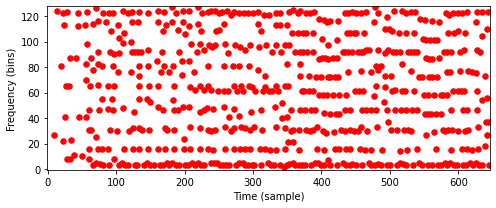

In [70]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

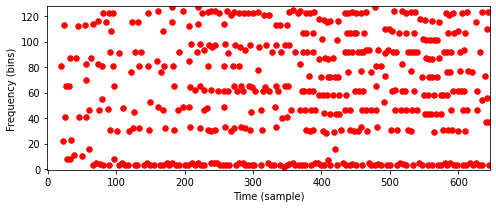

In [71]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

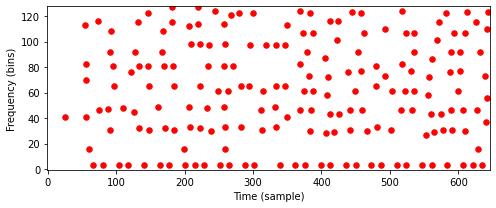

In [72]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

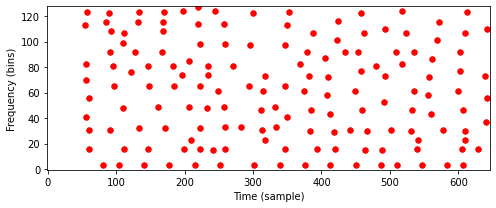

In [73]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

## Task 3

In [92]:
queries = load_filenames('queries')
for config in configs:
    config["cmaps_Q"] = compute_constellation_maps(queries, config["kappa"], config["tau"])

### ### Visualization of examples random querry for each configuration

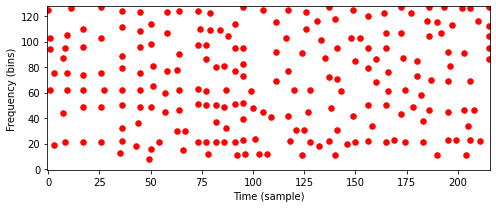

In [93]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

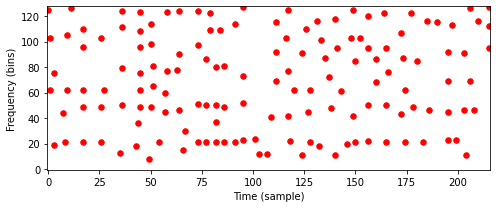

In [94]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

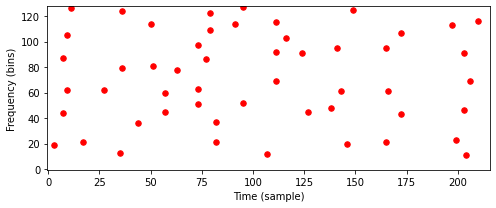

In [95]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

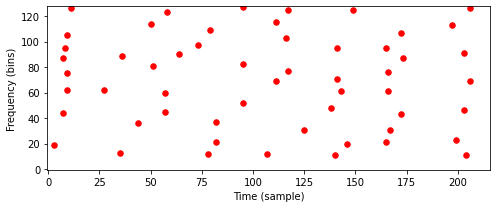

In [96]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

### Matching

In [101]:
for config in configs: # loop through all 4 configurations
    print(f"***** Configuration: κ={config['kappa']}, τ={config['tau']} *****")

    config["hits"] = {"total": 0, "short": 0, "noise": 0, "compression": 0, "mobile": 0}

    for name_Q, cmap_Q in config["cmaps_Q"].items(): # test all queries one by one
        best_score = 0
        best_name = None


        start_time = time.time() # measure time

        for name_D, cmap_D in config["cmaps_D"].items(): # compare query to all database tracks
            delta, shift_max = compute_matching_function(cmap_D, cmap_Q, tol_freq=config["tol_freq"], tol_time=config["tol_time"])

            if delta[shift_max] > best_score:
                best_score = delta[shift_max]
                best_name = name_D


        end_time = time.time()

        # save best matching track
        config["matches"][name_Q] = {"matching_track": best_name, "score": best_score, "time": (end_time-start_time)}

        # keep track of hits - it is a hit if the track number of the query filename is the same as of the track filename
        track_num = name_Q.split(os.path.sep)[2].split('_')[0]
        if track_num in best_name:
            config["hits"]["total"] += 1 # total hits

            if "noise" in name_Q:
                config["hits"]["noise"] += 1 # if query was a noise query
            elif "10k_16k" in name_Q:
                config["hits"]["compression"] += 1 # if query was a coding query
            elif "mobile" in name_Q:
                config["hits"]["mobile"] += 1 # if query was a mobile query
            elif "short" in name_Q:
                config["hits"]["short"] += 1 # if query the orginal extracted segment


    total_time = sum(entry["time"] for entry in config["matches"].values()) # total time it took for all queries of the given configuration
    average_time = total_time / len(config["matches"]) if config["matches"] else 0 # average query time of given configuration

    # print out short statistics for each configuration
    print(f"Average time per query: {average_time:.2f} seconds")
    print(f"Matched {config['hits']['total']} of {len(queries)} queries correctly.")
    print(f"Short: {config['hits']['short']} / {20}.")
    print(f"Noise: {config['hits']['noise']} / {20}.")
    print(f"Compression: {config['hits']['compression']} / {20}.")
    print(f"Mobile: {config['hits']['mobile']} / {20}.")



    print("\n\n")

***** Configuration: κ=7, τ=3 *****
Average time per query: 0.57 seconds
Matched 59 of 60 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 0 / 20.



***** Configuration: κ=11, τ=3 *****
Average time per query: 0.43 seconds
Matched 60 of 60 queries correctly.
Short: 20 / 20.
Noise: 20 / 20.
Compression: 20 / 20.
Mobile: 0 / 20.



***** Configuration: κ=10, τ=10 *****
Average time per query: 0.56 seconds
Matched 59 of 60 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 0 / 20.



***** Configuration: κ=6, τ=17 *****
Average time per query: 0.53 seconds
Matched 59 of 60 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 0 / 20.





## Task 4

In [104]:
import pandas as pd




# Example data
average_times = []
for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    average_times.append(average_time)

max_times = [max(entry["time"] for entry in config["matches"].values()) for config in configs]
min_times = [min(entry["time"] for entry in config["matches"].values()) for config in configs]



data = {
    "Average Query Time (sec)": average_times,
    "Max Query Time (sec)": max_times,
    "Min Query Time (sec)": min_times,
    "Total Accuracy (%)": [config["hits"]["total"]/len(queries) for config in configs],
    "Short Accuracy (%)": [(config["hits"]["short"]/20)*100 for config in configs],
    "Noise Accuracy (%)": [(config["hits"]["noise"]/20)*100 for config in configs],
    "Compression Accuracy (%)": [(config["hits"]["compression"]/20)*100 for config in configs],
    "Mobile Accuracy (%)": [(config["hits"]["mobile"]/20)*100 for config in configs],
}

# Row labels
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]

# Create the DataFrame
df = pd.DataFrame(data, index=labels)
df

,Average Query Time (sec),Max Query Time (sec),Min Query Time (sec),Total Accuracy (%),Short Accuracy (%),Noise Accuracy (%),Compression Accuracy (%),Mobile Accuracy (%)
"kappa=7, tau=3",0.568414,10.030362,0.248005,0.983333,100.0,95.0,100.0,0.0
"kappa=11, tau=3",0.426135,0.648931,0.255217,1.000000,100.0,100.0,100.0,0.0
"kappa=10, tau=10",0.563637,0.883390,0.396918,0.983333,100.0,95.0,100.0,0.0
"kappa=6, tau=17",0.529002,0.866373,0.398974,0.983333,100.0,95.0,100.0,0.0


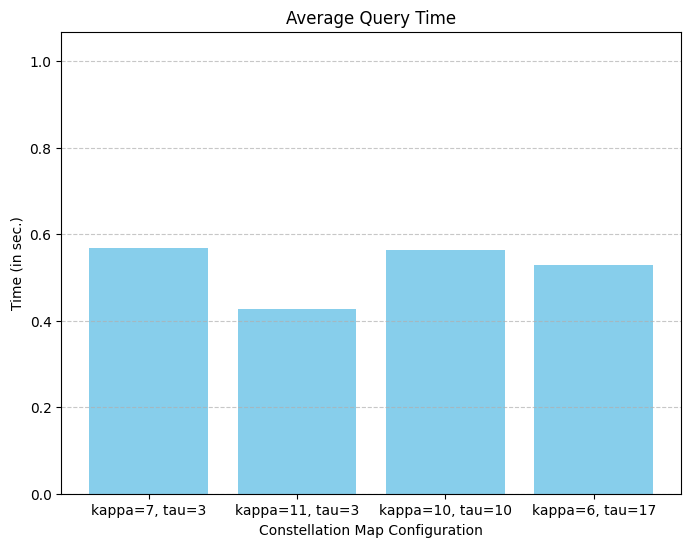

In [105]:
import matplotlib.pyplot as plt

# Values to plot
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
values = []

for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    values.append(average_time)

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Average Query Time')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Time (in sec.)')
plt.ylim(0, max(values) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

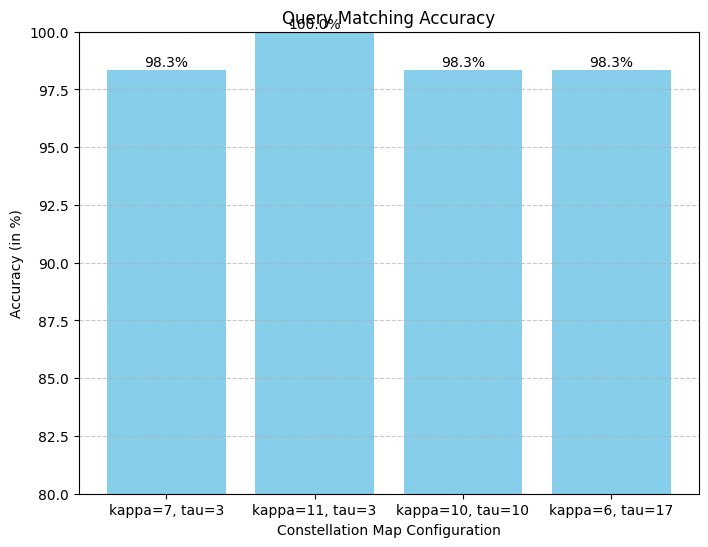

In [106]:
import matplotlib.pyplot as plt


# Values to plot
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
values = [config["hits"]["total"]/len(queries)*100 for config in configs]


# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color='skyblue')

# Adding percentages above the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Query Matching Accuracy')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Accuracy (in %)')
plt.ylim(80, 100)  # Leave some space above the bars for annotations
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

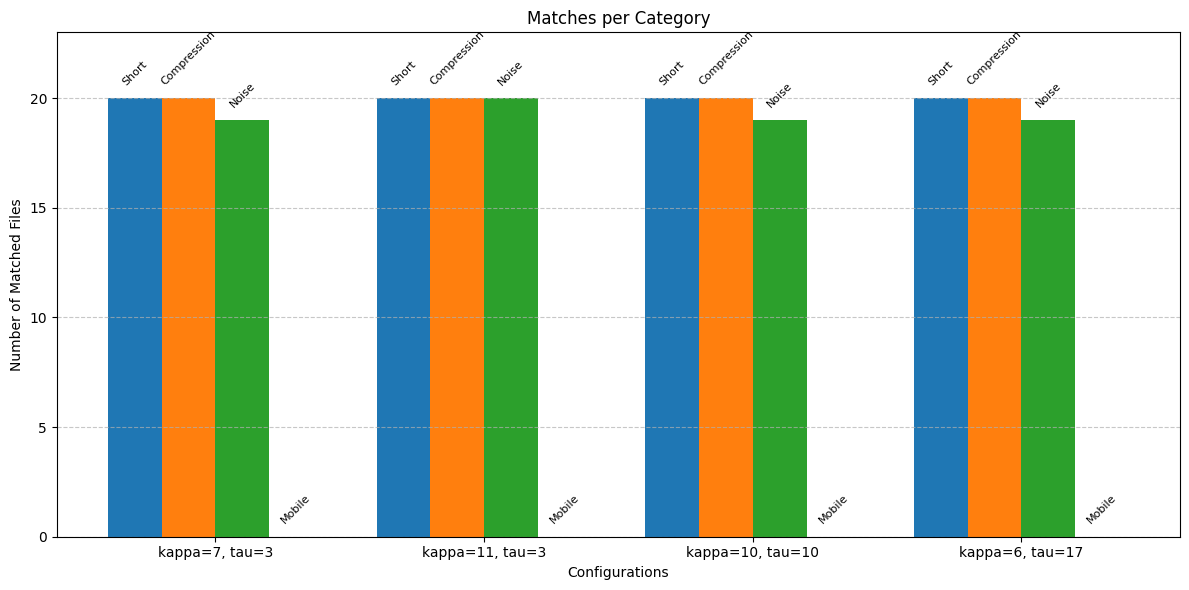

In [109]:
# Configuration names and corresponding counts for each category
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
matched_original = [config["hits"]["short"] for config in configs]
matched_coding = [config["hits"]["compression"] for config in configs]
matched_noise = [config["hits"]["noise"] for config in configs]
matched_mobile = [config["hits"]["mobile"] for config in configs]

# Number of configurations
num_configs = len(labels)

# X positions for groups of bars
x = np.arange(num_configs)

# Width of each bar
bar_width = 0.2

# Categories and their data
categories = ['Short', 'Compression', 'Noise', 'Mobile']
data = [matched_original, matched_coding, matched_noise, matched_mobile]

# Plot
plt.figure(figsize=(12, 6))

for i, category_data in enumerate(data):
    # Offset for each bar in a group
    bar_positions = x + (i - 1.5) * bar_width
    bars = plt.bar(bar_positions, category_data, width=bar_width)

    # Add category labels on top of each bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Adjusted offset for more space
                 categories[i], ha='center', va='bottom', rotation=45, fontsize=8)

# Add labels, title, and legend
plt.xlabel('Configurations')
plt.ylabel('Number of Matched Files')
plt.title('Matches per Category')
plt.xticks(x, labels)

# Adjust the y-axis to leave more space at the top
plt.ylim(0, max(max(matched_original), max(matched_coding), max(matched_noise), max(matched_mobile)) + 3)

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


------------------

kappa: 7 | tau: 3 | tol_freq: 0 | tol_time: 0
Maximum Score:
                                              Query  Score
48  queries\random_selection_short\24028_short.mp3  214.0

Minimum Score:
                                                Query  Score
39  queries\random_selection_noise\4628_gaussian.mp3   13.0

Average Score: 99.30864197530865
Average Score for `original` Queries: None
Average Score for `mobile` Queries: None
Average Score for `coding` Queries: None
Average Score for `noise` Queries: 104.75

------------------

kappa: 11 | tau: 3 | tol_freq: 0 | tol_time: 0
Maximum Score:
                                              Query  Score
55  queries\random_selection_short\31428_short.mp3  159.0

Minimum Score:
                                                Query  Score
38  queries\random_selection_noise\4628_gaussian.mp3    9.0

Average Score: 67.4
Average Score for `original` Queries: None
Average Score for `mobile` Queries: None
Average Score for `co

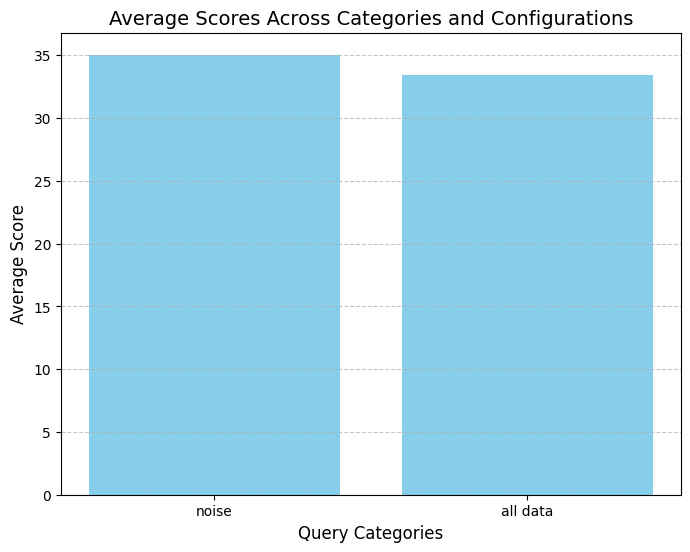

In [110]:
keys_to_print = ['kappa', 'tau', 'tol_freq', 'tol_time']
print("\n------------------\n")

for config in configs:
    key_values = " | ".join(f"{key}: {config[key]}" for key in keys_to_print if key in config)
    print(f"{key_values}")

    # Extract matches data
    matches_data = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
    ]
    matches_data_mobile = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "mobile" in query_name.lower()
    ]
    matches_data_code = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "coding" in query_name.lower()
    ]
    matches_data_noise = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "noise" in query_name.lower()
    ]
    matches_data_original = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "original" in query_name.lower()
    ]

    average_scores = {"mobile": [], "coding": [], "noise": [], "original": [], "all data": []}

    # Create DataFrames
    df = pd.DataFrame(matches_data)
    df_m = pd.DataFrame(matches_data_mobile)
    df_c = pd.DataFrame(matches_data_code)
    df_n = pd.DataFrame(matches_data_noise)
    df_o = pd.DataFrame(matches_data_original)

    # Ensure "Score" column is numeric where applicable
    df["Score"] = pd.to_numeric(df["Score"])
    average_score_m = None
    if not df_m.empty:
        df_m["Score"] = pd.to_numeric(df_m["Score"])
        average_score_m = df_m["Score"].mean()
    average_score_c = None
    if not df_c.empty:
        df_c["Score"] = pd.to_numeric(df_c["Score"])
        average_score_c = df_c["Score"].mean()
    average_score_n = None
    if not df_n.empty:
        df_n["Score"] = pd.to_numeric(df_n["Score"])
        average_score_n = df_n["Score"].mean()
    average_score_o = None
    if not df_o.empty:
        df_o["Score"] = pd.to_numeric(df_o["Score"])
        average_score_o = df_o["Score"].mean()

    for category, matches in zip(
        ["mobile", "coding", "noise", "original", "all data"],
        [df_m, df_c, df_n, df_o, df]
    ):
        df = pd.DataFrame(matches)
        if not df.empty:
            df["Score"] = pd.to_numeric(df["Score"])
            average_scores[category].append(df["Score"].mean())

    # Calculate max, min, and average for all queries
    max_row = df.nlargest(1, "Score")
    min_row = df.nsmallest(1, "Score")
    average_score = df["Score"].mean()

    # Print Results
    print("Maximum Score:\n", max_row)
    print("\nMinimum Score:\n", min_row)
    print("\nAverage Score:", average_score)
    print("Average Score for `original` Queries:", average_score_o)
    print("Average Score for `mobile` Queries:", average_score_m)
    print("Average Score for `coding` Queries:", average_score_c)
    print("Average Score for `noise` Queries:", average_score_n)
    print("\n------------------\n")

final_averages = {cat: pd.Series(scores).mean() for cat, scores in average_scores.items() if scores}

plt.figure(figsize=(8, 6))
categories = list(final_averages.keys())
scores = list(final_averages.values())

plt.bar(categories, scores, color='skyblue')
plt.title("Average Scores Across Categories and Configurations", fontsize=14)
plt.xlabel("Query Categories", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()